In [1]:
import numpy as np
from scipy.linalg import expm
from scipy.optimize import minimize
from scipy.stats import qmc
import itertools
import matplotlib.pyplot as plt
import galois
import time

In [2]:
# def cost_hamiltonian(p, B, F_list):
#     # implements the negation of  eq. (78) from DQI paper
#     omega = np.exp(2j * np.pi / p) # p-th root of unity
#     m, n = B.shape
#     dim = p ** n
#     diag_elements = np.zeros(dim, dtype=complex)
    
#     # since the generalised Z matrix is diagonal, to apply the matrix to the state,
#     # don't need to build the whole matrix but just get the diagonal elements of the tensor product
#     for i in range(m):
#         for v in F_list[i]:
#             for a in range(p):
#                 Z = np.zeros(dim, dtype=complex)
#                 for idx in range(dim):
#                     digits = [int(d, base=p) for d in np.base_repr(idx, base=p).zfill(n)]
#                     exponent = np.sum([a * B[i][j] * digits[j] for j in range(n)] + [-a * v]) % p
#                     Z[idx] = omega ** exponent
#                 diag_elements = diag_elements + Z
#     return -np.real_if_close(diag_elements) / p

def cost_hamiltonian(p, B, F_list):
    # implements the negation of eq. (75) from DQI paper
    m, n = B.shape
    diag_elements = np.zeros(p ** n)

    # since the generalised Z matrix is diagonal, to apply the matrix to the state,
    # don't need to build the whole matrix but just get the diagonal elements of the tensor product
    for idx, x in enumerate(itertools.product(range(p), repeat=n)):
        v = B @ GF(x)
        n_satisfied = sum([v[i] in F_list[i] for i in range(m)])
        diag_elements[idx] = n_satisfied

    return -diag_elements

In [3]:
def mixing_hamiltonian(n, p):
    # the generalised shift/Pauli X operator is not Hermitian when p > 2
    X = np.zeros((p, p))
    for i in range(p):
        X[(i + 1) % p, i] = 1
        
    dim = p ** n
    I = np.eye(p)
    mixing_h = np.zeros((dim, dim))
    for i in range(n):
        ops = [I] * n
        ops[i] = X
        tensor_prod = ops[0]
        for op in ops[1:]:
            tensor_prod = np.kron(tensor_prod, op)
        mixing_h += tensor_prod + tensor_prod.T # need to make it Hermitian by adding its adjoint
    return mixing_h

In [4]:
def simulate_qaoa_qudits(params, n_layers, n_params_per_layer, cost_h, mixing_eigvals, mixing_eigvecs, initial_state):
    state = initial_state
    for layer in range(n_layers):
        cost_unitary = np.exp(-1j * params[layer * n_params_per_layer] * cost_h) # vector
        mixing_unitary = mixing_eigvecs @ np.diag(np.exp(-1j * params[layer * n_params_per_layer + 1] * mixing_eigvals)) @ mixing_eigvecs.conj().T # matrix
        state = mixing_unitary @ (cost_unitary * state)
    return state

In [5]:
def cost_function(params, n_layers, n_params_per_layer, cost_h, mixing_eigvals, mixing_eigvecs, initial_state):
    state = simulate_qaoa_qudits(params, n_layers, n_params_per_layer, cost_h, mixing_eigvals, mixing_eigvecs, initial_state)
    return np.real(np.vdot(state, cost_h * state))

In [6]:
def display_results(sat_fractions, final_state, p, B, first=25):
    print("Best expected SAT fraction:", max(sat_fractions))

    m, n = B.shape
    l = (n + 1) // 2
    print("DQI paper semicircle law result:", 1 / 2 + np.sqrt(l / m * (1 - l / m)))
    
    prob_dist = abs(final_state) ** 2
    dim = p ** n
    coeffs = np.array(list(itertools.product(range(p), repeat=n)))
    plt.bar(range(dim), prob_dist)
    plt.xticks(range(dim), coeffs)
    plt.show()
    
    sorted_indices = np.flip(np.argsort(prob_dist))[:first]
    GF = galois.GF(p)
    for x, prob in zip(coeffs[sorted_indices], prob_dist[sorted_indices]):
        v = B @ GF(x)
        n_satisfied = sum([v[i] in F_list[i] for i in range(m)])
        print("coeffs:", x, "satisfying", n_satisfied, "constraints with probability", prob)

In [7]:
def verification(p, B, F_list):
    m, n = B.shape
    GF = galois.GF(p)
    v_dict = {}
    n_satisfied_dict = {}
    for x in itertools.product(range(p), repeat=n):
        v = B @ GF(x)
        v_dict[x] = v
        n_satisfied = sum([v[i] in F_list[i] for i in range(m)])
        n_satisfied_dict[x] = n_satisfied
    max_satisfied = max(n_satisfied_dict.values())
    max_satisfied_coeffs = [key for key, val in n_satisfied_dict.items() if val == max_satisfied]
    
    return max_satisfied_coeffs, max_satisfied, v_dict, n_satisfied_dict

In [8]:
p = 23 # prime number for the finite field
m = p - 1 # number of constraints, generally for max-LINSAT, m can be any integer, OPI is a special case with m = p - 1
n = 2 # number of coefficients in the polynomial of degree n - 1
GF = galois.GF(p)
primitives = GF.primitive_elements
primitive = primitives[0]
B = GF.Vandermonde(primitive, m, n) # B has a special structure known as Vandermonde matrix for OPI

r = p // 2
rng = np.random.default_rng(151609)
F_list = [rng.permutation(p)[:r] for i in range(m)] # subsets of the finite field that the polynomial should intersect at each point
# F_list = [[primitive ** i, primitive ** i + GF(4)] for i in range(m)] 
# F_list = [[1, 2], [3, 4], [0, 4], [2, 3]]
n_layers = 1
n_params_per_layer = 2
n_trials = 128

cost_h = cost_hamiltonian(p, B, F_list)
mixing_h = mixing_hamiltonian(n, p)
mixing_eigvals, mixing_eigvecs = np.linalg.eigh(mixing_h)
initial_state = np.ones(p ** n, dtype=np.complex64)/np.sqrt(p ** n) # |+> state for each qudit (uniform superposition)

In [9]:
def optimize(n_layers, n_params_per_layer, n_trials, cost_h, mixing_eigvals, mixing_eigvecs, initial_state):
    n_params = n_layers * n_params_per_layer
    all_params = np.zeros((n_trials, n_params))
    for layer in range(n_layers):
        sampler = qmc.Sobol(d=n_params_per_layer, scramble=True, seed=123 * (layer + 1))
        all_params[:, layer * n_params_per_layer : layer * n_params_per_layer + 2] = 2 * np.pi * sampler.random(n_trials)
    
    bounds = [(0, 2 * np.pi)] * n_params
    sat_fractions = np.zeros(n_trials)
    success_list = [0] * n_trials
    status_array = np.zeros(n_trials)
    nit_array = np.zeros(n_trials)
    for t in range(n_trials):
        params = all_params[t]
        results = minimize(
            lambda x: cost_function(x, n_layers, n_params_per_layer, cost_h, mixing_eigvals, mixing_eigvecs, initial_state),
            x0=params,
            method='L-BFGS-B',
            bounds=bounds,
            options={'maxiter': 100}
        )
        opt_params = results.x
        all_params[t] = opt_params
        sat_fractions[t] = -results.fun / m
        success_list[t] = results.success
        status_array[t] = results.status
        nit_array[t] = results.nit

    return all_params, sat_fractions, success_list, status_array, nit_array

Best expected SAT fraction: 0.5517264561945422
DQI paper semicircle law result: 0.7082988952252655


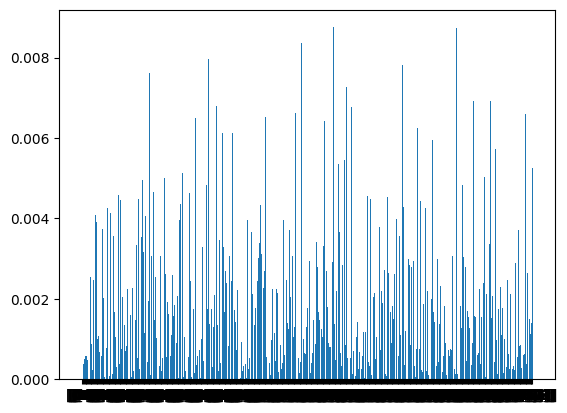

coeffs: [12 19] satisfying 9 constraints with probability 0.008752702848932729
coeffs: [19  2] satisfying 12 constraints with probability 0.008732929759890685
coeffs: [11  4] satisfying 11 constraints with probability 0.008360955098075178
coeffs: [22  4] satisfying 10 constraints with probability 0.00797096681553254
coeffs: [ 6 10] satisfying 15 constraints with probability 0.007970271188592837
coeffs: [16  8] satisfying 11 constraints with probability 0.007811376836938135
coeffs: [ 3 10] satisfying 14 constraints with probability 0.0076280312505969065
coeffs: [13 11] satisfying 14 constraints with probability 0.007264829009770272
coeffs: [2 8] satisfying 12 constraints with probability 0.007156880997127307
coeffs: [0 8] satisfying 12 constraints with probability 0.007087681075147255
coeffs: [20 19] satisfying 13 constraints with probability 0.0069230708786696465
coeffs: [19 22] satisfying 12 constraints with probability 0.0069152268734579215
coeffs: [ 6 20] satisfying 11 constraints w

In [10]:
opt_params, sat_fractions, success_list, status_array, nit_array = optimize(n_layers, n_params_per_layer, n_trials, cost_h, mixing_eigvals, mixing_eigvecs, initial_state)
final_state = simulate_qaoa_qudits(opt_params[-1], n_layers, n_params_per_layer, cost_h, mixing_eigvals, mixing_eigvecs, initial_state)
display_results(sat_fractions, final_state, p, B)

In [11]:
expected_results, max_satisfied, output_dict, n_satisfied_dict = verification(p, B, F_list)
print("coeffs that satify max number of constraints:", expected_results)
print("max number of satisfied constraints:", max_satisfied)
# print(output_dict)
# print(n_satisfied_dict)

coeffs that satify max number of constraints: [(10, 6), (15, 14), (18, 19)]
max number of satisfied constraints: 17
